# Project

- Table of Content
    - [Project Configuration](engine_id.ipynb#project-configuration)
    - [Reproducability](engine_id.ipynb#reproducibility--device)
    - [Dataset](engine_id.ipynb#dataset)
    - [Pre-processing](engine_id.ipynb#pre-processing)
    - [Convolutional Neural Network](engine_id.ipynb#convolutional-neural-network)
    - [Optimizer and Scheduler](engine_id.ipynb#optimizer--scheduler)
    - [Combine Everything](engine_id.ipynb#combine-everything)
    - [Run](engine_id.ipynb#run)


In [2]:
import math
import random
import numpy as np

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedShuffleSplit

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler

from collections import Counter
from dataclasses import dataclass
from pathlib import Path
from typing import Callable, Dict, List, Optional, Sequence, Tuple, Union


from __future__ import annotations

# Our own custom signal processing library
from signal_processing import process_audio_wav

## Project Configuration


In [3]:
@dataclass
class Config:
    """Top-level configuration for the training run.

    Attributes:
        data_dir: Root directory containing class subfolders of wav files.

        use_cepstrum: If True, use the cepstrum dataset; otherwise spectrum.

        batch_size_train: Batch size for training.

        batch_size_val: Batch size for evaluation.

        test_size: Fraction of data reserved for validation (0 < test_size < 1).

        seed: Random seed used across numpy/torch/random.

        lr: Initial learning rate for Adam.

        weight_decay: L2 regularization coefficient.

        epochs: Number of training epochs.

        num_workers: DataLoader workers; 0 is often fastest on small CPU jobs.
        
        pin_memory: Set True when training on CUDA; False on pure CPU is fine.
    """
    data_dir: str = "data/data_dir"
    use_cepstrum: bool = False
    batch_size_train: int = 32
    batch_size_val: int = 128
    test_size: float = 0.2
    seed: int = 42
    lr: float = 1e-3
    weight_decay: float = 1e-4
    epochs: int = 40
    num_workers: int = 0
    pin_memory: bool = False

## Reproducibility & device

In [4]:
def set_seed(seed: int) -> None:
    """Set random seeds for reproducible experiments.

    Args:
        seed: Integer seed applied to Python, NumPy, and PyTorch RNGs.
    """
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [5]:
def get_device() -> torch.device:
    """Select an available computation device.

    Returns:
        A `torch.device` set to CUDA if available; otherwise CPU.
    """
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Dataset

In [6]:
# Helper functions for finding wave files in the directory

def is_wav(p: Path) -> bool:
    return p.suffix.lower() == ".wav"

def _discover_wavs(root) -> List[Tuple[Path, int]]:
    """
    Discover .wav files

    Parameters
    ----------
        root (path or str): The root directory of the categorized audio files
                            The file structure should look like this:
                                root/
                                    4/
                                        *.wav
                                    6/
                                        *.wav
                                    8/
                                        *.wav
                                    ....

    Returns
    -------
        items (List[Tuple[Path, int]]): A list of tuples of .wav file path
                                        and the number of cylinders

    """
    root = Path(root)
    items = []
    for cls_dir in sorted(root.iterdir()):
        if not cls_dir.is_dir():
            continue
        try:
            cylinders = int(cls_dir.name)
        except ValueError:
            continue
        for wav in sorted(cls_dir.rglob("*.wav")):
            if is_wav(wav):
                items.append((wav, cylinders))
    if not items:
        raise FileNotFoundError(f"No wavs found under {root}")
    return items


In [7]:
# PyTorch Dataset Core Object

class _BaseEngineAudioDataset(Dataset):
    """
    Base Dataset that calls process_audio_wav and returns either spectrum or 
    cepstrum.

    Parameters
    ----------
        root_dir : str | Path
            Root containing class folders (e.g., 4,6,8).
            The file structure should look like this:
                root/
                    4/
                        *.wav
                    6/
                        *.wav
                    8/
                        *.wav
                    ....
        mode : str
            'spectrum' or 'cepstrum' (which feature to return as X).

        process_kwargs : dict
            Keyword args forwarded to process_audio_wav.
            
        to_channel_first : bool
            If True, X is returned as (1, L) for easy 1D-CNN use. 
            If False, shape is (L,).

        transform : Optional[Callable[[torch.Tensor], torch.Tensor]]
            Optional transform applied to X (after to_channel_first).

        target_transform : Optional[Callable[[int], int]]
            Transform applied to y_class (the 0..C-1 class index).

        return_cylinders_as_target : bool
            If True, y is the raw cylinder count (e.g., 4,6,8). 
            NOTE: CrossEntropyLoss
            expects targets in 0..C-1; if you set this True, 
            use an appropriate loss.

        cache_in_memory : bool
            If True, keep processed features in RAM to speed up subsequent 
            epochs.
    """
    def __init__(
        self,
        root_dir: Union[str, Path],
        mode: str,
        process_kwargs: Optional[dict] = None,
        to_channel_first: bool = True,
        transform: Optional[Callable[[torch.Tensor], torch.Tensor]] = None,
        target_transform: Optional[Callable[[int], int]] = None,
        return_cylinders_as_target: bool = False,
        cache_in_memory: bool = True,
    ) -> None:
        super().__init__()
        assert mode in ("spectrum", "cepstrum")
        self.root_dir = Path(root_dir)
        self.mode = mode
        self.process_kwargs = process_kwargs or {}
        self.to_channel_first = to_channel_first
        self.transform = transform
        self.target_transform = target_transform
        self.return_cylinders_as_target = return_cylinders_as_target
        self.cache_in_memory = cache_in_memory

        # Discover files and raw cylinder labels
        pairs = _discover_wavs(self.root_dir)  # [(path, cylinders), ...]
        self.wavs: List[Path] = [p for p, _ in pairs]
        cyls: List[int] = [c for _, c in pairs]

        # Make stable mapping: class_index <-> cylinders
        uniq = sorted(set(cyls))               # e.g., [4, 6, 8]
        self.class_to_cylinders: Dict[int, int] = {i: v for i, v in enumerate(uniq)}
        self.cylinders_to_class: Dict[int, int] = {v: i for i, v in self.class_to_cylinders.items()}

        self.y_class: List[int] = [self.cylinders_to_class[c] for c in cyls]  # 0..C-1 per sample
        self.y_cylinders: List[int] = cyls                                   # e.g., 4/6/8 per sample

        # Optional in-RAM cache: index -> (torch.FloatTensor X, int y)
        self._cache: Dict[int, Tuple[torch.Tensor, int]] = {}

    def __len__(self) -> int:
        return len(self.wavs)

    def _compute_features(self, idx: int) -> Tuple[torch.Tensor, int]:
        # Call user's processing function
        p = str(self.wavs[idx])
        spectrum_power, cepstrum_mag, spectrum_order, cepstrum_qref = process_audio_wav(
            p, **self.process_kwargs
        )
        # Select feature by mode
        if self.mode == "spectrum":
            x_np = np.asarray(spectrum_power, dtype=np.float32)  # shape (L_spec,)
        else:  # 'cepstrum'
            x_np = np.asarray(cepstrum_mag, dtype=np.float32)    # shape (L_ceps,)

        x = torch.from_numpy(x_np)  # (L,)
        if self.to_channel_first:
            x = x.unsqueeze(0)       # (1, L) for Conv1d

        return x, self.y_class[idx]

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        # Serve from cache if enabled
        if self.cache_in_memory and idx in self._cache:
            x, y_class = self._cache[idx]
        else:
            x, y_class = self._compute_features(idx)
            if self.cache_in_memory:
                self._cache[idx] = (x, y_class)

        # Apply transforms
        if self.transform is not None:
            x = self.transform(x)

        if self.return_cylinders_as_target:
            y = self.y_cylinders[idx]  # e.g., 4/6/8
        else:
            y = y_class                # 0..C-1

        if self.target_transform is not None:
            y = self.target_transform(y)

        return x, y


In [8]:
# Creating Spectrum and Cepstrum classes

class EngineSpectrumDataset(_BaseEngineAudioDataset):
    def __init__(self, root_dir, **kwargs):
        super().__init__(root_dir, mode="spectrum", **kwargs)

class EngineCepstrumDataset(_BaseEngineAudioDataset):
    def __init__(self, root_dir, **kwargs):
        super().__init__(root_dir, mode="cepstrum", **kwargs)

## Pre-processing
Building dataset, spliting test samples, balancing the dataset

In [9]:

def zscore_transform(x: torch.Tensor) -> torch.Tensor:
    """Apply per-sample z-score normalization to a (C, L) tensor.

    z = (x - mean) / std, computed across the last dimension (time/frequency).

    Args:
        x: Tensor of shape (C, L). Typically C=1 for 1D Conv input.

    Returns:
        Tensor of shape (C, L) with normalized values.
    """
    m = x.mean(dim=-1, keepdim=True)
    s = x.std(dim=-1, keepdim=True) + 1e-8
    return (x - m) / s


In [10]:
def build_dataset(cfg: Config):
    """Create the spectrum or cepstrum dataset with a z-score transform.

    Args:
        cfg: Run configuration.

    Returns:
        A PyTorch Dataset that yields tuples (X, y), where:
          - X: Float tensor of shape (1, L) (channel-first)
          - y: Integer class index in [0, num_classes).
    """
    DSClass = EngineCepstrumDataset if cfg.use_cepstrum else EngineSpectrumDataset
    ds = DSClass(
        cfg.data_dir,
        process_kwargs=dict(
            nperseg=4096, noverlap=256,
            num_peaks=3,
            num_orders=8, bins_per_interval=30,
            normalize_at_1x=False,
            to_decibel=True
        ),
        to_channel_first=True,      # -> (1, L) for Conv1d
        transform=zscore_transform, # normalize each sample consistently
        return_cylinders_as_target=False,
        cache_in_memory=True,
    )
    return ds

In [11]:
def stratified_split_indices(y: np.ndarray, test_size: float, seed: int) -> Tuple[np.ndarray, np.ndarray]:
    """Create stratified train/val indices to preserve class ratios.

    Args:
        y: Array of class indices for the full dataset, shape (N,).
        test_size: Fraction of samples assigned to validation.
        seed: Random seed for the split.

    Returns:
        (train_idx, val_idx): Two numpy arrays of indices into the dataset.
    """
    idx_all = np.arange(len(y))
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)
    train_idx, val_idx = next(sss.split(idx_all, y))
    return train_idx, val_idx

In [12]:
def make_balanced_loaders(
    ds,
    train_idx: np.ndarray,
    val_idx: np.ndarray,
    cfg: Config
) -> Tuple[DataLoader, DataLoader]:
    """Create training and validation DataLoaders with a balanced train sampler.

    The training loader uses a WeightedRandomSampler to approximately balance
    the class distribution in each epoch. The validation loader is deterministic.

    Args:
        ds: Dataset instance built by `build_dataset`.
        train_idx: Numpy array of training indices.
        val_idx: Numpy array of validation indices.
        cfg: Run configuration.

    Returns:
        (train_loader, val_loader): Two DataLoader objects.
    """
    train_set = Subset(ds, train_idx)
    val_set   = Subset(ds, val_idx)

    # Build per-sample weights (inverse class frequency on TRAIN)
    y_train = np.array([ds.y_class[i] for i in train_idx])
    num_classes = len(ds.class_to_cylinders)
    class_counts = np.bincount(y_train, minlength=num_classes).astype(np.float64)
    class_weights = 1.0 / np.maximum(class_counts, 1.0)
    sample_weights = class_weights[y_train]

    sampler = WeightedRandomSampler(
        weights=torch.from_numpy(sample_weights).double(),
        num_samples=len(sample_weights),
        replacement=True
    )

    train_loader = DataLoader(
        train_set,
        batch_size=cfg.batch_size_train,
        sampler=sampler,
        num_workers=cfg.num_workers,
        pin_memory=cfg.pin_memory
    )
    val_loader = DataLoader(
        val_set,
        batch_size=cfg.batch_size_val,
        shuffle=False,
        num_workers=cfg.num_workers,
        pin_memory=cfg.pin_memory
    )
    return train_loader, val_loader

## Convolutional Neural Network

In [13]:
class SimpleCNN1D(nn.Module):
    """A minimal 1D CNN classifier for fixed-length 1D features.

    Architecture:
        Conv1d(1→16, k=7, pad=3) + ReLU + MaxPool(2)
        Conv1d(16→32, k=5, pad=2) + ReLU + MaxPool(2)
        Conv1d(32→64, k=3, pad=1) + ReLU
        AdaptiveAvgPool1d(1) → Flatten → Linear(64→num_classes)

    Input:
        (N, 1, L) float32

    Output:
        (N, num_classes) logits (use CrossEntropyLoss)
    """
    def __init__(self, num_classes: int):
        """Initialize layers.

        Args:
            num_classes: Number of target classes.
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=7, padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2),

            nn.Conv1d(16, 32, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2),

            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(64, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass.

        Args:
            x: Input tensor of shape (N, 1, L).

        Returns:
            Logits tensor of shape (N, num_classes).
        """
        return self.net(x)

In [14]:
def build_model(num_classes: int, device: torch.device) -> nn.Module:
    """Construct and move the model to a device.

    Args:
        num_classes: Number of classes for the final classifier.
        device: torch.device (CPU or CUDA).

    Returns:
        A model instance on the specified device.
    """
    model = SimpleCNN1D(num_classes=num_classes).to(device)
    return model

## Optimizer / Scheduler

In [15]:

def build_optimizer(model: nn.Module, cfg: Config) -> optim.Optimizer:
    """Create an Adam optimizer for the model parameters.

    Args:
        model: The neural network to optimize.
        cfg: Run configuration with lr and weight_decay.

    Returns:
        A configured torch.optim.Optimizer instance.
    """
    return optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)


def build_scheduler(optimizer: optim.Optimizer):
    """Build a ReduceLROnPlateau scheduler driven by validation accuracy.

    Args:
        optimizer: The optimizer to schedule.

    Returns:
        A torch.optim.lr_scheduler.ReduceLROnPlateau instance.
    """
    return torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="max", factor=0.5, patience=3
    )

## Train and Eval

In [16]:
def train_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    optimizer: optim.Optimizer,
    criterion: nn.Module,
    device: torch.device
) -> Tuple[float, float]:
    """Train the model for one epoch.

    Args:
        model: Neural network in training mode.
        loader: DataLoader providing (X, y) mini-batches.
        optimizer: Optimizer for parameter updates.
        criterion: Loss function (e.g., nn.CrossEntropyLoss()).
        device: torch.device to run the computation on.

    Returns:
        Tuple (avg_loss, avg_accuracy) over the epoch.
    """
    model.train()
    total, correct, running = 0, 0, 0.0
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        running += loss.item() * xb.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == yb).sum().item()
        total += xb.size(0)
    return running / max(total, 1), correct / max(total, 1)


In [17]:
@torch.no_grad()
def evaluate(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    device: torch.device
) -> Tuple[float, float, np.ndarray, np.ndarray]:
    """Evaluate the model on a validation/test loader.

    Args:
        model: Neural network in eval mode.
        loader: DataLoader providing (X, y) mini-batches.
        criterion: Loss function (e.g., nn.CrossEntropyLoss()).
        device: torch.device to run the computation on.

    Returns:
        Tuple (avg_loss, avg_accuracy, y_true, y_pred):
            - avg_loss: Mean loss across the dataset.
            - avg_accuracy: Fraction correct.
            - y_true: Numpy array of ground-truth class indices.
            - y_pred: Numpy array of predicted class indices.
    """
    model.eval()
    total, correct, running = 0, 0, 0.0
    all_pred, all_true = [], []
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        logits = model(xb)
        loss = criterion(logits, yb)

        running += loss.item() * xb.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == yb).sum().item()
        total += xb.size(0)

        all_pred.append(pred.cpu().numpy())
        all_true.append(yb.cpu().numpy())

    y_pred = np.concatenate(all_pred) if all_pred else np.array([])
    y_true = np.concatenate(all_true) if all_true else np.array([])
    return running / max(total, 1), correct / max(total, 1), y_true, y_pred

## Combine Everything

In [18]:
def run_training(cfg: Config) -> Tuple[nn.Module, DataLoader, torch.device]:
    """End-to-end training run: dataset, loaders, model, training, metrics.
    This function prints per-epoch train/val loss/accuracy and a final
    confusion matrix + classification report.
    Args:
        cfg: Configuration values that drive the whole pipeline.
    Returns:
        Tuple containing the trained model, training DataLoader, and device.
    Raises:
        RuntimeError: If the dataset has fewer than 2 classes.
    """
    set_seed(cfg.seed)
    device = get_device()

    # Dataset
    ds = build_dataset(cfg)
    num_classes = len(ds.class_to_cylinders)
    if num_classes < 2:
        raise RuntimeError("Need at least 2 classes for classification.")

    # Stratified split
    y_all = np.array(ds.y_class)
    train_idx, val_idx = stratified_split_indices(y_all, cfg.test_size, cfg.seed)

    # Loaders
    train_loader, val_loader = make_balanced_loaders(ds, train_idx, val_idx, cfg)

    # Model / Optim / Sched / Loss
    model = build_model(num_classes=num_classes, device=device)
    optimizer = build_optimizer(model, cfg)
    scheduler = build_scheduler(optimizer)
    criterion = nn.CrossEntropyLoss()  # unweighted (balanced sampler already compensates)


    print(model)
    
    # Train
    best_val_acc = 0.0
    for ep in range(1, cfg.epochs + 1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        va_loss, va_acc, y_true, y_pred = evaluate(model, val_loader, criterion, device)
        scheduler.step(va_acc)

    #Evaluate
    model.eval()

    # Create a DataLoader for the dataset
    loader = DataLoader(ds, batch_size=64, shuffle=False, num_workers=0)

    # Collect predictions and true labels
    all_preds = []
    all_labels = []
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        logits = model(xb)  # Forward pass
        preds = logits.argmax(dim=1)  # Get class predictions
        all_preds.append(preds.cpu().numpy())  # Move to CPU and convert to numpy
        all_labels.append(yb.numpy())  # True labels

    # Concatenate all predictions and labels into single arrays
    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_labels)

    cm = confusion_matrix(y_true, y_pred)
    return cm

## Run

In [20]:
def main(seed) -> Tuple[nn.Module, DataLoader, torch.device]:
    """Entry point for running the training with default (editable) config.

    Edits you commonly make:
        - Config.data_dir: set to your dataset root
        - Config.use_cepstrum: switch to cepstrum features
        - Config.epochs / lr: tweak training length and learning rate

    Returns:
        Tuple containing the trained model, training DataLoader, and device.
    """
    cfg = Config(
        data_dir="data/data_dir",   # <-- set your folder here
        use_cepstrum=True,    # True for cepstrum dataset
        epochs=1,
        lr=1e-4,
        weight_decay=1e-4,
        batch_size_train=64,
        batch_size_val=64,
        test_size=0.1,
        seed=seed,
        num_workers=0,
        pin_memory=False,
    )
    return run_training(cfg)

cm_list = []
num_models = 1
for x in range(num_models):
    #print(f"Models trained: {x} of {num_models}", end="\r")
    cm_list.append(main(seed=x))



SimpleCNN1D(
  (net): Sequential(
    (0): Conv1d(1, 16, kernel_size=(7,), stride=(1,), padding=(3,))
    (1): ReLU(inplace=True)
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (4): ReLU(inplace=True)
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (7): ReLU(inplace=True)
    (8): AdaptiveAvgPool1d(output_size=1)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=64, out_features=5, bias=True)
  )
)


In [88]:
import time
for cm in cm_list:
    print(cm, end='\r')
    time.sleep(0.5)

[[33  0  0  0  0]
 [42  0  0  0  0]
 [19  0  0  0  0]
 [ 3  0  0  0  0]
[[ 0 33  0  0  0]]
 [ 0 42  0  0  0]
 [ 0 19  0  0  0]
 [ 0  3  0  0  0]
[[ 0  0  0  0 33]]
 [ 0  0  0  0 42]
 [ 0  0  0  0 19]
 [ 0  0  0  0  3]
[[ 0  0 33  0  0]]
 [ 0  0 42  0  0]
 [ 0  0 19  0  0]
 [ 0  0  3  0  0]
[[ 0 33  0  0  0]]
 [ 0 42  0  0  0]
 [ 0 19  0  0  0]
 [ 0  3  0  0  0]


In [19]:
def count_parameters(model):
    """Count the total number of trainable parameters in a model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Example usage
total_params = count_parameters(model)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 9253


## Loss Landscape Visualization
This section visualizes the loss landscape by perturbing the model parameters along two random directions and plotting the loss as a 2D surface.

In [20]:
from visualization import visualize_loss_landscape_2d, visualize_loss_landscape_3d

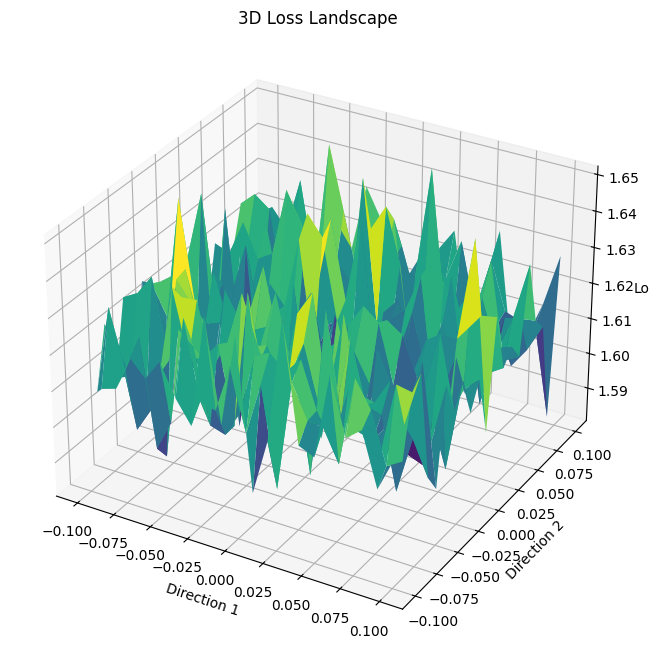

In [21]:
# Example usage of the loss landscape visualization with the trained model

def visualize_trained_model_loss_landscape():
    """
    Visualize the loss landscape of the trained model returned from main().
    Assumes `model`, `train_loader`, and `device` are already defined.
    """
    from visualization import visualize_loss_landscape_2d

    # Define the loss criterion
    criterion = nn.CrossEntropyLoss()

    # Visualize the 2D loss landscape
    visualize_loss_landscape_3d(model, criterion, train_loader, device, p1=0.1, p2=0.1)

# Call the visualization function
visualize_trained_model_loss_landscape()

In [54]:
from visualization import random_loss

# Example usage of random loss landscape visualization
loss_samples = random_loss(model, nn.CrossEntropyLoss(), train_loader, device, num_trials=100000)

In [55]:
#convert loss samples to numpy array
loss_samples_np = np.array(loss_samples['loss'])
accuracy_samples_np = np.array(loss_samples['accuracy'])

#save loss samples
import numpy as np
np.save('loss_samples.npy', loss_samples_np)
np.save('accuracy_samples.npy', accuracy_samples_np)


In [3]:
# Calculate mean and variance
accuracy_values = [sample for sample in loss_samples['accuracy']]
mean_accuracy = np.mean(accuracy_values)
variance_accuracy = np.var(accuracy_values)

print(f"Mean Accuracy: {mean_accuracy:0.4f}")
print(f"Variance of Accuracy: {variance_accuracy:0.4f}")

x_vals_acc = np.linspace(min(accuracy_values), max(accuracy_values), 1000)
# Calculate the y values using the Gaussian PDF
y_vals_acc = (1 / (np.sqrt(2 * np.pi * variance_accuracy))) * np.exp(-((x_vals_acc - mean_accuracy) ** 2) / (2 * variance_accuracy))



NameError: name 'loss_samples' is not defined

In [ ]:
max(accuracy_values)


0.4880952380952381